In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib
from glob import glob

import sys
sys.path.append("../scripts")
from experiments import load_split, PROTECTED_ATTRIBUTES

from credit_pipeline import training, evaluate
from credit_pipeline.training import EBE # small fix to be able to load models

%load_ext autoreload
%autoreload 2


2024-05-02 14:40:28.645353: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 14:40:28.681105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 14:40:28.681125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 14:40:28.682203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 14:40:28.687971: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 14:40:28.688811: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
dataset_name = "homecredit"
seed = 0

plot of logistic regression feature importance, gbm feature importance, and shap feature importance of both models

In [98]:
path = "../results/credit_models"
lr_features_importance = []
lgbm_features_importance = []
shap_lr_features_importance = []
shap_lgbm_features_importance = []
for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    X_train_preprocess = model[:-1].transform(X_train)
    features = X_train_preprocess.columns.tolist()

    categoric_features = model[1].transformers_[1][1].get_feature_names_out()
    categoric_features_mapping = model[1].transformers_[1][1].categories_
    categoric_features_mapping = {f: c for f, c in zip(categoric_features, categoric_features_mapping)}
    
    lr_features_importance.append(model[-1].coef_[0])

    explainer =shap.LinearExplainer(
       model[-1],
        X_train_preprocess.sample(1000),
        feature_perturbation="interventional",
    )
    shap_values = explainer(X_train_preprocess.sample(10000))
    shap_lr_features_importance.append(shap_values.values.mean(0))

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    lgbm_features_importance.append(model[-1].feature_importances_)

    explainer = shap.TreeExplainer(
        model[-1],
        X_train_preprocess.sample(1000),
        model_output="probability",
        feature_perturbation="interventional",
        
    )
    shap_values = explainer(X_train_preprocess.sample(10000))
    shap_lgbm_features_importance.append(shap_values.values.mean(0))
   

lr_features_importance = np.array(lr_features_importance)
lgbm_features_importance = np.array(lgbm_features_importance)
shap_lr_features_importance = np.array(shap_lr_features_importance)
shap_lgbm_features_importance = np.array(shap_lgbm_features_importance)

 99%|===================| 9870/10000 [01:08<00:00]        

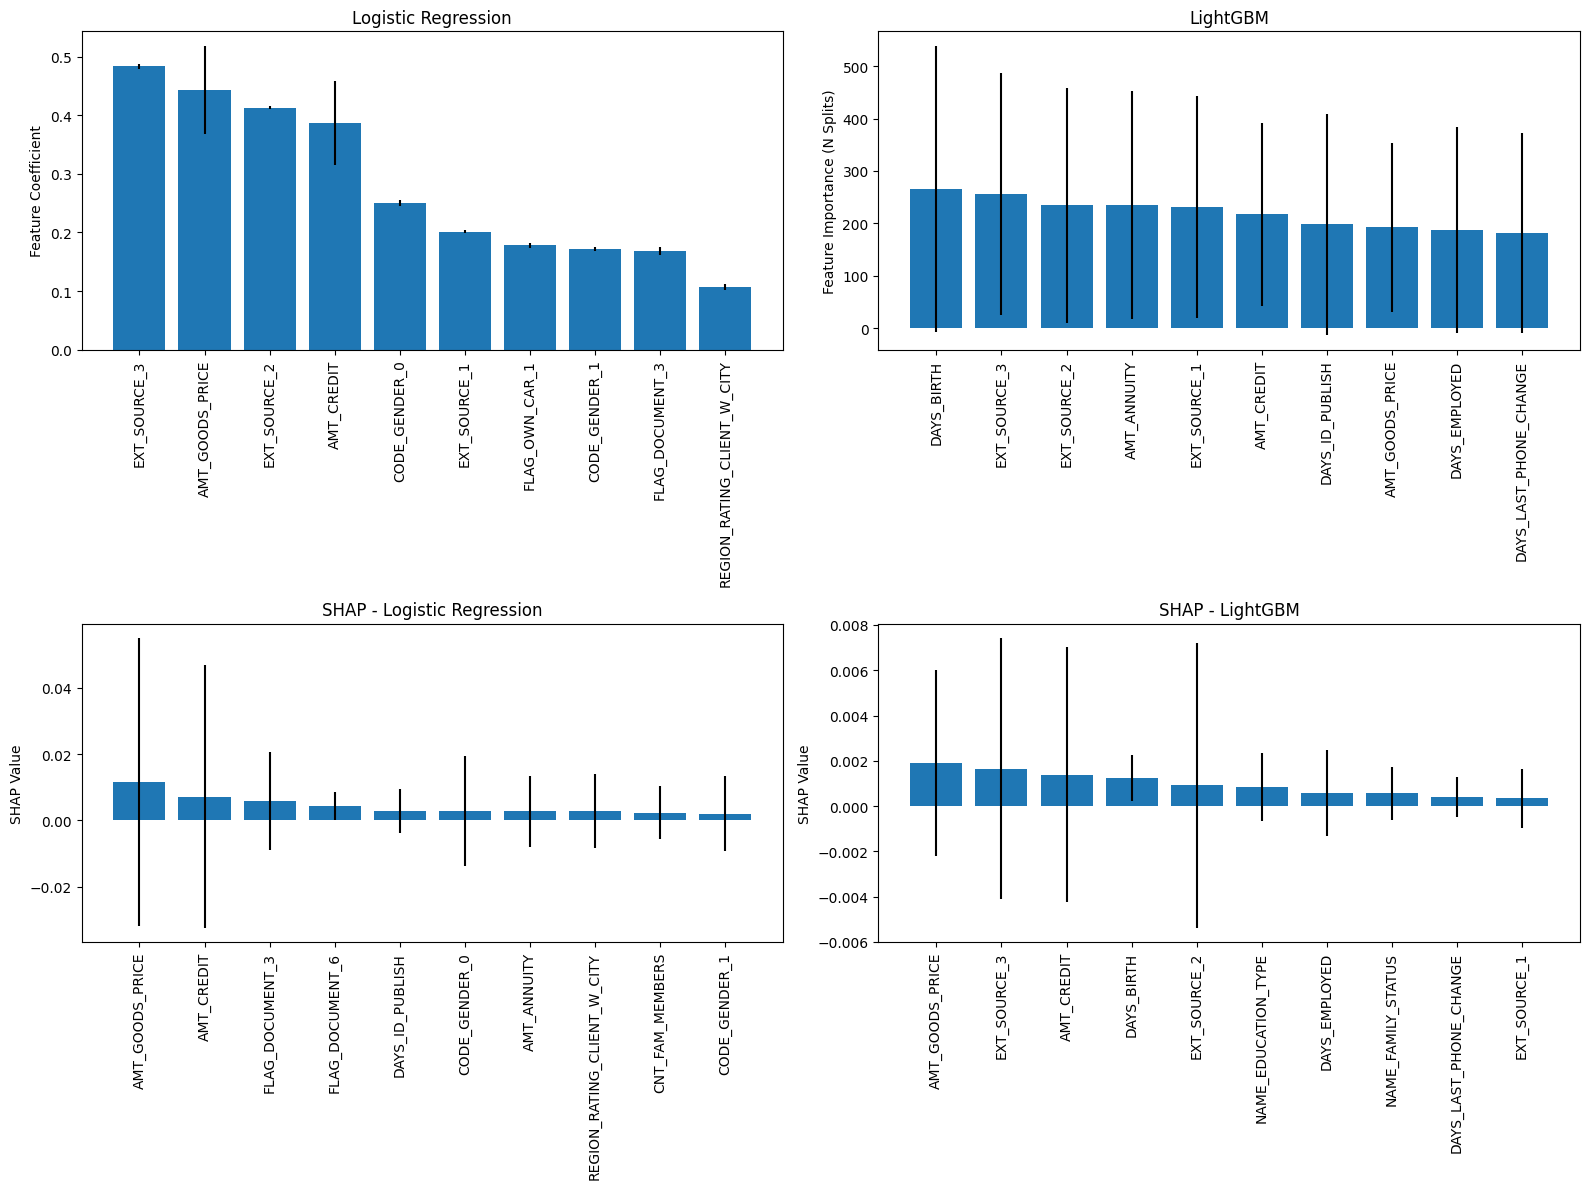

In [99]:
fig, axs = plt.subplots(nrows = 2, ncols =2, figsize = (16, 12))
axs = axs.flatten()


def get_more_important_features(importance_values, features):
    mean_sorted = np.abs(importance_values.mean(axis=0))
    std_sorted = importance_values.std(axis=0)
    sorted_idx = np.argsort(mean_sorted)[::-1][:10]
    features_sorted = np.array(features)[sorted_idx]
    mean_sorted = mean_sorted[sorted_idx]
    std_sorted = std_sorted[sorted_idx]
    return features_sorted, mean_sorted, std_sorted

features_sorted, mean_sorted, std_sorted = get_more_important_features(lr_features_importance, features)
axs[0].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[0].set_title("Logistic Regression")
axs[0].set_ylabel("Feature Coefficient")
axs[0].set_xticklabels(features_sorted, rotation=90)

features_sorted, mean_sorted, std_sorted = get_more_important_features(lgbm_features_importance, features)
axs[1].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[1].set_title("LightGBM")
axs[1].set_xticklabels(features_sorted, rotation=90)
axs[1].set_ylabel("Feature Importance (N Splits)")

features_sorted, mean_sorted, std_sorted = get_more_important_features(shap_lr_features_importance, features)
axs[2].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[2].set_title("SHAP - Logistic Regression")
axs[2].set_ylabel("SHAP Value")
axs[2].set_xticklabels(features_sorted, rotation=90)

features_sorted, mean_sorted, std_sorted = get_more_important_features(shap_lgbm_features_importance, features)
axs[3].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[3].set_title("SHAP - LightGBM")
axs[3].set_ylabel("SHAP Value")
axs[3].set_xticklabels(features_sorted, rotation=90)


plt.tight_layout()
plt.savefig("test.pdf")
plt.show()

In [104]:
from sklearn.inspection import partial_dependence

a = partial_dependence(model[-1], X_train_preprocess, features = ["AMT_CREDIT"], grid_resolution=100, percentiles=(0.05, 0.95), method="brute")

In [ ]:
path = "../results/credit_models"
lr_pdp = []
lgbm_pdp = []
for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    X_train_preprocess = model[:-1].transform(X_train)
    pdp = partial_dependence(model[-1], X_train_preprocess, features = ["AMT_CREDIT"], grid_resolution=100, percentiles=(0.05, 0.95), method="brute")
    lr_pdp.append(pdp)

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    pdp = partial_dependence(model[-1], X_train_preprocess, features = ["AMT_CREDIT"], grid_resolution=100, percentiles=(0.05, 0.95), method="brute")
    lgbm_pdp.append(pdp)